In [1]:
using Plots
using Printf
using CovarianceWoodbury
using StatsBase
plotlyjs()

Plots.PlotlyJSBackend()

In [2]:
using FITSIO, EasyFITS
path = "/Users/ferreol/Data/Gravity+/2022-01-19/Calibration/"
T = 5
Δt = [0.3,1,3,30,60]

darkdata = Array{Array{Float64,3},1}(undef,T)
darkdata[1] =read(FITS(path*"shortdark/GRAVI.2022-01-20T12:02:49.587.fits")[6]);
darkdata[2] =read(FITS(path*"shortdark/GRAVI.2022-01-20T10:54:38.338.fits")[6]);
darkdata[3] =read(FITS(path*"gooddark/GRAVI.2022-01-20T10:57:23.345.fits")[6]);
darkdata[4] =read(FITS(path*"gooddark/GRAVI.2022-01-20T10:38:29.298.fits")[6]);
darkdata[5] =read(FITS(path*"gooddark/GRAVI.2022-01-20T11:03:35.360.fits")[6]);



In [3]:
l = 131
rnk = 10
m = Array{Array{Float64,1},1}(undef,T)
Cemp = Array{Array{Float64,2},1}(undef,T)
Cdiag = Array{Array{Float64,2},1}(undef,T)
Cest = Array{Array{WoodburyCovariance{Float64, 2},1},1}(undef,T)

for n=1:T
	m[n] = mean(darkdata[n],dims=3)[l,:,1]
	Cemp[n] = cov(darkdata[n][l,:,2:end] .-m[n],dims=2)
	Cdiag[n] = var(darkdata[n][l,:,2:end] .-m[n],dims=2)
	Cest[n] = Array{WoodburyCovariance{Float64, 2},1}(undef,rnk)
	for k=1:rnk
		Cest[n][k] = buildCovariance(darkdata[n][l,:,2:end] .-m[n], k);
	end
end



In [25]:

Cest_svd = Array{Array{WoodburyCovariance{Float64, 2},1},1}(undef,T)


for n=1:T
	Cest_svd[n] = Array{WoodburyCovariance{Float64, 2},1}(undef,rnk)
	for k=1:rnk
		Cest_svd[n][k] = buildCovariance(Val(:svd),darkdata[n][l,:,2:end] .-m[n], k);
	end
end



In [4]:

"""
    find_peaks!(vect::AbstractVector{<:Real};
				 dist::Integer = 5,
				 rtol::Real = 0.1,
				 atol::Real = 0.0,
				 nmax::Integer = typemax(Int))

find_peaks!(vect) -> inds

yields the indices of the most significant local maxima found in vector `vect`
destroying the contents of `vect` in the process.  The indices are returned in
decreasing order of peak heights.

The following keywords can be used to tune the algorithm:

* `dist` (5 by default) specifies the minimal distance (in indices units)
between two peaks.

* `atol` (0.0 by default) and `rtol` (0.1 by default) specify the absolute and
relative tolerances for the detection threshold.  If `atol` is NaN, the
detection threshold is `rtol*maximum(vect)`; otherwise, the detection
threshold is `max(atol, rtol*maximum(vect))`.  All selected peaks have values
greater or equalt the detection threshold.

* `nmax` (no limits by default) specifies the maximum number of peaks to
detect.

Call `find_peaks` to avoid overwriting `vect`.

"""
function find_peaks!(vect::AbstractVector{<:Real};
				 dist::Integer = 5,
				 rtol::Real = 0.1,
				 atol::Real = 0.0,
				 nmax::Integer = typemax(Int))
dist ≥ 1 || error("minimal distance must be ≥ 1")
0 ≤ rtol ≤ 1 || error("invalid relative threshold")

dst = Int(dist) - 1
vmin = typemin(eltype(vect))
vtol = float(atol)
I = axes(vect, 1)
I_first, I_last = first(I), last(I)
inds = Int[]
while length(inds) < nmax
	vmax, imax = findmax(vect)
	if length(inds) < 1
		# Compute selection threshold.
		v = oftype(vtol, rtol*vmax)
		if isnan(vtol)
			vtol = v
		else
			vtol = max(vtol, v)
		end
	end
	vmax ≥ vtol || break
	push!(inds, imax)
	@inbounds for i in max(I_first, imax - dst):min(I_last, imax + dst)
		vect[i] = vmin
	end
end
return inds
end

"""
find_peaks(vect) -> inds

yields the indices of the most significant local maxima found in vector `vect`.

See `find_peaks!` for a list of accepted keywords.

"""
find_peaks(vect::AbstractVector, args...; kwds...) =
find_peaks!(copy(vect), args...; kwds...)


find_peaks

In [5]:
flatdata = Array{Array{Float64,3},1}(undef,4)
flatdata[1] =read(FITS(path*"GRAVI.2022-01-20T12:04:16.590.fits")[6]);
flatdata[2] =read(FITS(path*"GRAVI.2022-01-20T12:05:19.593.fits")[6]);
flatdata[3] =read(FITS(path*"GRAVI.2022-01-20T12:06:22.596.fits")[6]);
flatdata[4] =read(FITS(path*"GRAVI.2022-01-20T12:07:25.598.fits")[6]);


In [6]:

M,N,K = size(flatdata[1])
meanflat = mean(mean(flatdata) .- mean(darkdata[1],dims=3),dims=3)[l,:,1]
peaks = find_peaks(meanflat)
sort!(peaks)
@assert length(peaks) ==24
pattern = zeros(24,N)
for n=1:24
	pattern[n,(peaks[n]-4):(peaks[n]+4)] .= meanflat[(peaks[n]-4):(peaks[n]+4)] ./ sqrt.(sum(abs2,meanflat[(peaks[n]-4):(peaks[n]+4)]))
end
support = (sum(pattern,dims=1) .==1)[:];

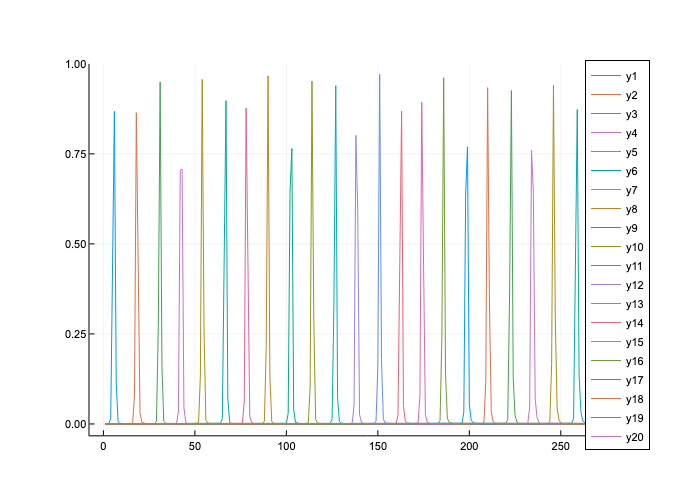

In [7]:
plot(pattern')

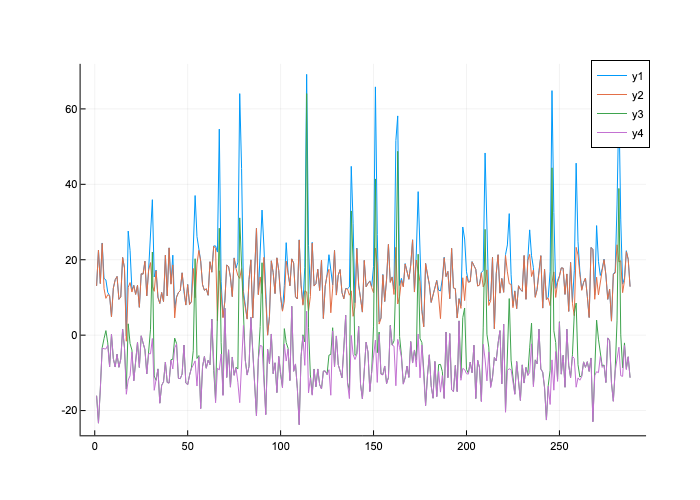

In [104]:
SNR = 10 #dB
nt=5

lvl = 10^(SNR/20 + log10(std(darkdata[nt][l,:,:].- m[nt]))) ;
a = lvl * (2 .*rand(24))
df = plot(darkdata[nt][l,:,15] .- m[nt] .+ pattern'* a)
plot!(df,darkdata[nt][l,:,15] .- m[nt] )
plot!(df,darkdata[nt][l,:,14] .- m[nt] .+ pattern'* a)
plot!(df,darkdata[nt][l,:,14] .- m[nt] )

In [105]:

lvl = 10^(SNR/20 + log10(std(darkdata[nt][l,:,:].- m[nt]))) ;
a = lvl * (2 .*rand(24))
lvl

30.46355554432805

In [106]:

H = pattern'
y = darkdata[nt][l,:,1] .- m[nt] .+ H * a
a_est = Array{Array{Float64,1},1}(undef,rnk)
for k = 1:rnk
	a_est[k] = (H' *(Cest[nt][k] \ H )) \ H' * (Cest[nt][k]\ y)
end
a_emp = (H' *(Cemp[nt] \ H )) \ H' * (Cemp[nt]\ y)
a_diag = (H' *(Cdiag[nt] .\ H )) \ H' * (Cdiag[nt] .\ y)
err =hcat(a_est...,  H' *   y,   a_diag) .- a 
show(mean(err, dims=1))
show(var(err, dims=1))

[-0.6646729204137721 -0.33730010622636203 -0.32679071212818134 -1.7366072291723162 -1.0986763964211563 0.07260727719482342 -0.6752553701321794 -0.6975939194109403 -1.817334798169675 1.9474262378673695 -6.0184163700532025 -6.506479091702534][55.917602227713665 50.05276665533838 52.6652580636938 49.140327319934144 57.606484908538995 44.10763269226187 49.63861572070801 54.37463717642305 47.54489791189874 72.21704187124898 54.62857698141552 57.11561318869746]

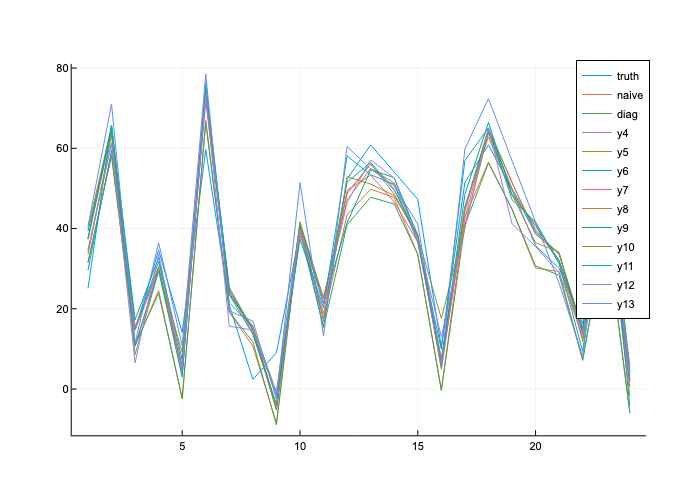

In [107]:
fa = plot(a, labels="truth")
plot!(fa,H' *   y;labels="naive")
plot!(fa,a_diag;labels="diag")
plot!(fa,a_est)

In [115]:
H = pattern'
y = darkdata[nt][l,:,1] .- m[nt] .+ H * a
bias = median( (darkdata[nt][l,:,1] .- m[nt])[.! support])

a_est = Array{Array{Float64,1},1}(undef,rnk)
for k = 1:rnk
	a_est[k] = (H' *(Cest[nt][k] \ H )) \ H' * (Cest[nt][k]\ y)
end
a_emp = (H' *(Cemp[nt] \ H )) \ H' * (Cemp[nt]\ y)
a_diag = (H' *(Cdiag[nt] .\ H )) \ H' * (Cdiag[nt] .\ (y .- bias))
a_naive =  H' *  (y .- bias)
err =hcat(a_est...,a_naive ,   a_diag) .- a 
show(mean(err, dims=1))
println()
show(var(err, dims=1))
println()
show(mean(abs2,err,dims=1))

[-0.6646729204137721 -0.33730010622636203 -0.32679071212818134 -1.7366072291723162 -1.0986763964211563 0.07260727719482342 -0.6752553701321794 -0.6975939194109403 -1.817334798169675 1.9474262378673695 0.11042826260854421 -0.17922487685388]
[55.917602227713665 50.05276665533838 52.6652580636938 49.140327319934144 57.606484908538995 44.10763269226187 49.63861572070801 54.37463717642305 47.54489791189874 72.21704187124898 53.283493487288276 55.02491193823382]
[54.02949222602363 48.08100607302626 50.577664480573134 50.10861835001711 56.41330452806952 42.27508648011928 48.02630988057086 52.59566457047122 48.86656626754137 73.00046741188116 51.07554232650066 52.76432883062404]

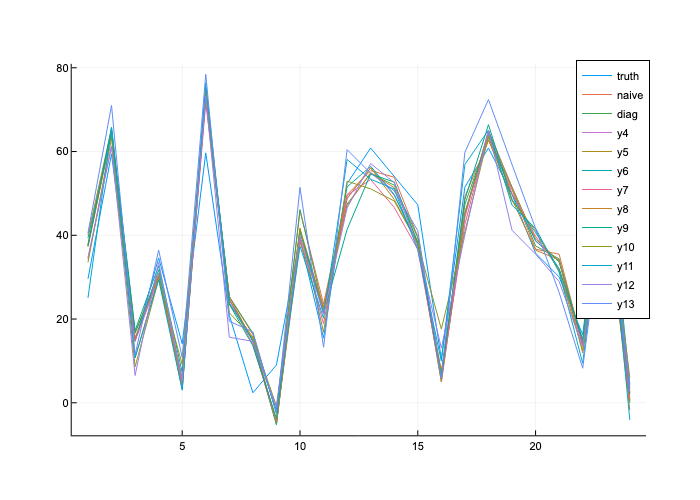

In [116]:
fa = plot(a, labels="truth")
plot!(fa,a_naive;labels="naive")
plot!(fa,a_diag;labels="diag")
plot!(fa,a_est)

In [117]:
H = pattern'
y = darkdata[nt][l,:,1] .- m[nt] .+ H * a
bias = median( (darkdata[nt][l,:,1] .- m[nt])[.! support])

a_svd = Array{Array{Float64,1},1}(undef,rnk)
for k = 1:rnk
	a_svd[k] = (H' *(Cest_svd[nt][k] \ H )) \ H' * (Cest_svd[nt][k]\ y)
end
a_emp = (H' *(Cemp[nt] \ H )) \ H' * (Cemp[nt]\ y)
a_diag = (H' *(Cdiag[nt] .\ H )) \ H' * (Cdiag[nt] .\ (y .- bias))
a_naive =  H' *  (y .- bias)
err =hcat(a_svd...,a_naive ,   a_diag) .- a 
show(mean(err, dims=1))
println()
show(var(err, dims=1))
println()
show(mean(abs2,err,dims=1))

[-0.6684597270599907 -0.7066441171203737 -0.35826947220669214 -0.3956061099732678 -1.4160016411116312 -1.2649035165290456 -1.6061242388452228 -1.5267862566996546 1.6890299450775619 -1.8245787639976696 0.11042826260854421 -0.17922487685388]
[56.040764876829066 52.79947459604399 52.517612767965915 44.78775862281085 52.692951026854125 48.800661870657976 47.41963131282791 45.84582605966092 60.24791456416763 42.621221625309595 53.283493487288276 55.02491193823382]
[54.152571413662294 51.09884239613633 50.457735917349275 43.07810620777525 52.50247204836604 48.3672818655081 48.02344841206622 46.266659580821994 60.59040694602934 44.17442505695297 51.07554232650066 52.76432883062404]

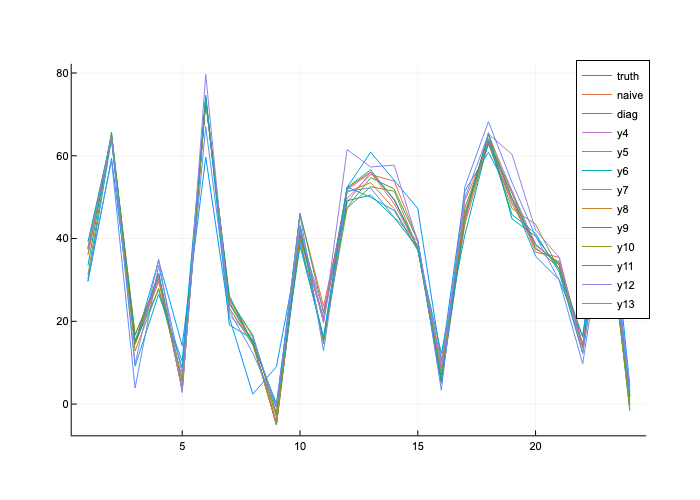

In [118]:
fa = plot(a, labels="truth")
plot!(fa,a_naive;labels="naive")
plot!(fa,a_diag;labels="diag")
plot!(fa,a_svd)

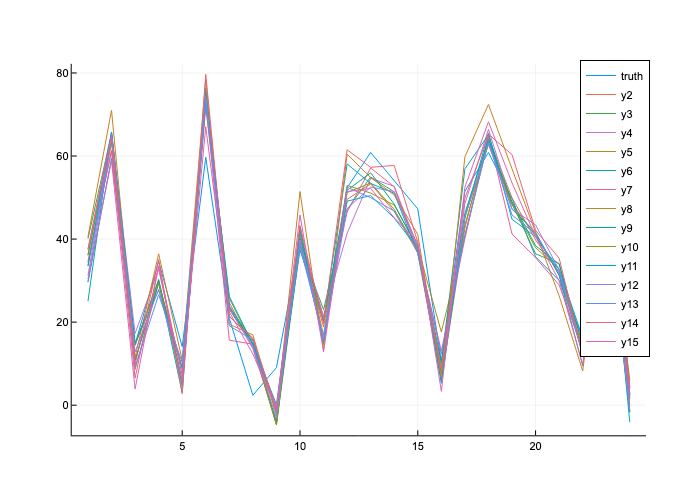

In [119]:
fa = plot(a, labels="truth")
plot!(fa,a_est[4:end])
plot!(fa,a_svd[4:end])

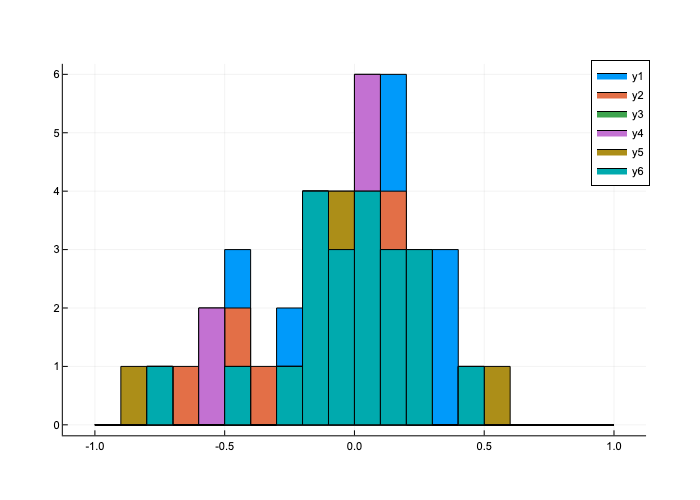

In [120]:
histogram((hcat(a_est[10],a_svd[10],a_est[1],a_svd[1],a_naive,a_diag) .- a)./a, bin =-1:0.1:1)

In [121]:
sqrt.(mean(abs2,(hcat(a_est[10],a_svd[10],a_est[1],a_svd[1],a_naive,a_diag) .- a)./a,dims=1))

1×6 Matrix{Float64}:
 1.29268  0.920022  1.15552  1.1562  1.25572  1.28507